In [1]:
# Enter the file name of .ini file with settings for ATClean:
config_file = 'config.ini'

##### LOADING THE SN LIGHT CURVE #####

# Enter the target SN name:
tnsname = '2019vxm'

# Enter the path to the directory with light curves in ATClean-readable format:
atclean_input_dir = '/Users/sofiarest/Desktop/Supernovae/data_refactor/atclean_input'

# Enter the path to the directory with cleaned and averaged light curves, plots, efficiency tables, and more:
output_dir = '/Users/sofiarest/Desktop/Supernovae/data_refactor/output/misc' 

# Enter the path to a directory to optionally save any plots:
plots_dir = f'{output_dir}/{tnsname}/plots'

# Enter the filter:
filt = 'o'

# Enter the MJD bin size of the averaged light curves in days (set to None to skip loading):
mjd_bin_size = 1.0

# Optionally, enter the SN's MJD0 (if None is entered, the discovery date will be 
# fetched automatically from TNS using the API key, TNS ID, and bot name):
mjd0 = 58768.040000
api_key = None
tns_id = None
bot_name = None

##### LOADING CONTROL LIGHT CURVES #####

# If True, load control light curves; else, don't
load_controls = True

# Enter the number of control light curves to load:
n_controls = 7

##### PLOTTING #####

# If True, try to calculate the best y limits automatically for each plot;
# if False, leave y limits to matplotlib 
auto_xylimits = True

In [2]:
# import dependencies
import sys, os
from download import load_config
from lightcurve import CutList, Supernova, AveragedSupernova, LightCurve, AveragedLightCurve, Cut, AandB, AnotB, AorB, not_AandB, query_tns, get_tns_mjd0_from_json
from plot import PlotLimits, Plot
from clean import hexstring_to_int
import numpy as np
from copy import deepcopy
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# plot styling settings
plt.rc('axes', titlesize = 17)
plt.rc('xtick', labelsize = 12)
plt.rc('ytick', labelsize = 12)
plt.rc('legend', fontsize = 10)
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=['red', 'orange', 'green', 'blue', 'purple', 'magenta'])
matplotlib.rcParams['xtick.major.size'] = 6
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['xtick.minor.size'] = 3
matplotlib.rcParams['xtick.minor.width'] = 1
matplotlib.rcParams['ytick.major.size'] = 6
matplotlib.rcParams['ytick.major.width'] = 1
matplotlib.rcParams['ytick.minor.size'] = 3
matplotlib.rcParams['ytick.minor.width'] = 1
matplotlib.rcParams['axes.linewidth'] = 1
marker_size = 30
marker_edgewidth = 1.5

plot = Plot(plots_dir)

# Load the config file

In [3]:
config = load_config(config_file)


Loading config file at config.ini...


# Load the light curves

In [4]:
print(f'SN {tnsname}, filter {filt}, {n_controls} control light curves')
if not mjd0 is None:
	print(f'SN discovery date: {mjd0}')
else:
	print(f'TNS credentials: \n\tAPI key: {api_key}\n\tTNS ID: {tns_id}\n\tBot name: {bot_name}')
print(f'Load controls: {load_controls}')
print(f'Load averaged light curves: {f"True (MJD bin size: {mjd_bin_size} days)" if not mjd_bin_size is None else "False"}')

print()
print(f'ATClean output directory (load original light curves in ATClean-readable format): \n\t{atclean_input_dir}/{tnsname}')
print(f'ATClean output directory (load cleaned light curves): \n\t{output_dir}/{tnsname}')
print(f'Plots directory (save plots): \n\t{plots_dir}')

SN 2019vxm, filter o, 8 control light curves
SN discovery date: 58768.04
Load controls: True
Load averaged light curves: True (MJD bin size: 1.0 days)

ATClean output directory (load original light curves in ATClean-readable format): 
	/Users/sofiarest/Desktop/Supernovae/data_refactor/atclean_input/2019vxm
ATClean output directory (load cleaned light curves): 
	/Users/sofiarest/Desktop/Supernovae/data_refactor/output/misc/2019vxm
Plots directory (save plots): 
	/Users/sofiarest/Desktop/Supernovae/data_refactor/output/misc


In [5]:
if mjd0 is None:
	# get discovery date from TNS
	print(f"Querying TNS for SN {tnsname} discovery date...")
	json_data = query_tns(
		tnsname,
		api_key,
		tns_id,
		bot_name,
	)
	mjd0 = get_tns_mjd0_from_json(json_data)
	print(f"Setting MJD0 to {mjd0}")

# load cleaned light curves
sn = Supernova(tnsname=tnsname, mjd0=mjd0, filt=filt)
try:
	sn.load_all(output_dir, num_controls=n_controls, cleaned=True)
except Exception as e:
	raise RuntimeError(f"ERROR: Could not load light curves: {str(e)}")

if not mjd_bin_size is None:
	# load averaged light curves
	avg_sn = AveragedSupernova(tnsname=tnsname, mjd0=mjd0, filt=filt, mjdbinsize=mjd_bin_size)
	try:
		avg_sn.load_all(output_dir, num_controls=n_controls)
	except Exception as e:
		raise RuntimeError(f"ERROR: Could not load light curves: {str(e)}")


Loading SN light curve and 8 control light curves...
ERROR: could not read /Users/sofiarest/Desktop/Supernovae/data_refactor/output/misc/2019vxm/controls/2019vxm_i001.o.clean.lc.txt!
Could not load control light curve 1; skipping...
Successfully loaded SN light curve and 7 control light curves

Loading averaged SN light curve and 8 averaged control light curves...
ERROR: could not read /Users/sofiarest/Desktop/Supernovae/data_refactor/output/misc/2019vxm/controls/2019vxm_i001.o.1.00days.lc.txt!
Could not load control light curve 1; skipping...
Successfully loaded averaged SN light curve and 7 averaged control light curves


# Plot original SN light curve and control light curves

In [6]:
# Plot the control light curves?
plot_controls = True

# Plot the ATLAS template changes?
plot_template_changes = True

# Optionally, manually enter the x and y limits:
xlim_lower = None
xlim_upper = None
ylim_lower = None
ylim_upper = None

# Save the plot in the given plot_dir?
save = True

Calculating plot limits using light curve...
Plot limits: x-axis [None, None], y-axis [None, None]
Saving plot: /Users/sofiarest/Desktop/Supernovae/data_refactor/output/misc/2019vxm/plots/original.png


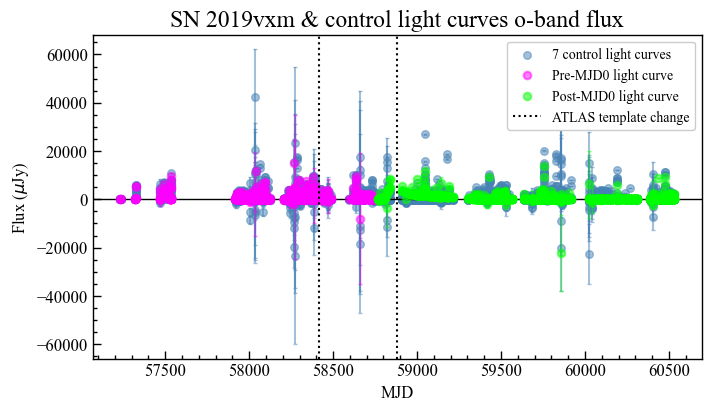

In [7]:
if plot_controls and not load_controls:
	raise RuntimeError('ERROR: No control light curves loaded; set plot_controls to False or load them')

lims = plot.get_lims(lc=sn.lcs[0], xlower=xlim_lower, xupper=xlim_upper, ylower=ylim_lower, yupper=ylim_upper)
print(lims)

plot.plot_SN(sn, lims, plot_controls=plot_controls, plot_template_changes=plot_template_changes, save=save)

# Plot the uncertainty cut

In [8]:
# Optionally, manually enter the x and y limits:
xlim_lower = None
xlim_upper = None
ylim_lower = None
ylim_upper = None

# Save the plot in the given plot_dir?
save = True

Calculating plot limits using light curve and given indices...
Plot limits: x-axis [None, None], y-axis [None, None]
Saving plot: /Users/sofiarest/Desktop/Supernovae/data_refactor/output/misc/2019vxm/plots/uncert_cut.png


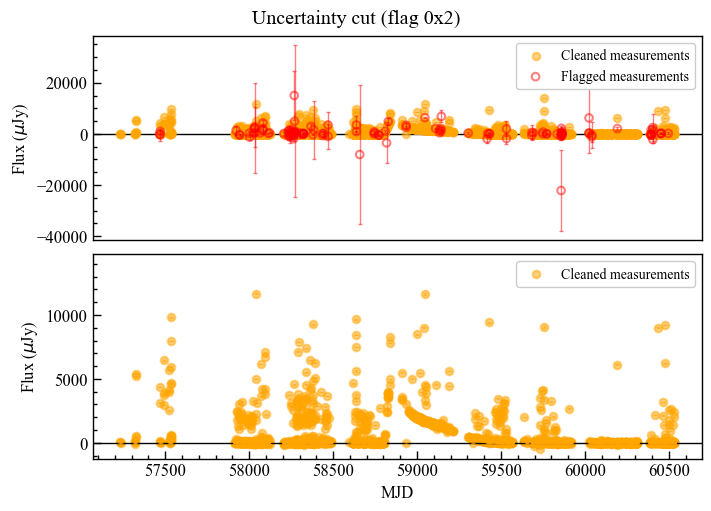

In [9]:
uncert_cut = Cut(flag=hexstring_to_int(config["uncert_cut"]["flag"]))

lims = plot.get_lims(lc=sn.lcs[0], indices=sn.lcs[0].get_good_indices(uncert_cut.flag), xlower=xlim_lower, xupper=xlim_upper, ylower=ylim_lower, yupper=ylim_upper)
print(lims)

plot.plot_cut(sn.lcs[0], uncert_cut.flag, lims, title='Uncertainty cut', save_filename = 'uncert_cut' if save else None)

# Plot the estimated true uncertainties

In [28]:
# Optionally, manually enter the x and y limits:
xlim_lower = None
xlim_upper = None
ylim_lower = -500
ylim_upper = 500

# Save the plot in the given plot_dir?
save = True

Plot limits: x-axis [None, None], y-axis [-500, 500]
Saving plot: /Users/sofiarest/Desktop/Supernovae/data_refactor/output/misc/2019vxm/plots/uncert_est.png


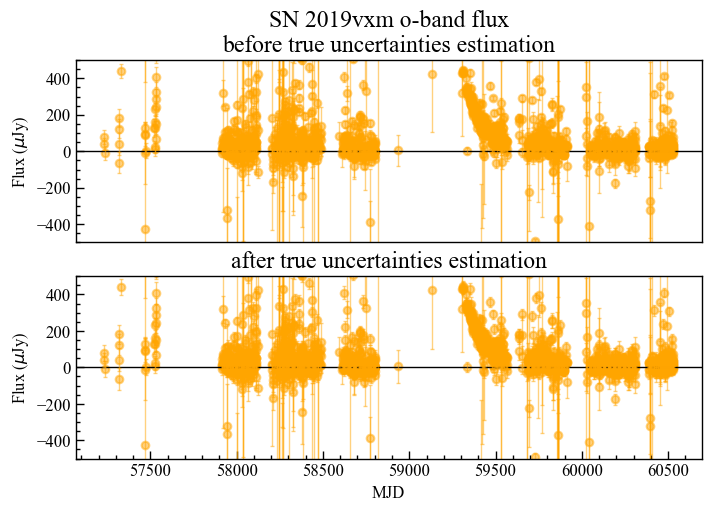

In [29]:
lims = plot.get_lims(lc=sn.lcs[0], indices=sn.lcs[0].get_good_indices(uncert_cut.flag), xlower=xlim_lower, xupper=xlim_upper, ylower=ylim_lower, yupper=ylim_upper)
print(lims)

plot.plot_uncert_est(sn.lcs[0], sn.tnsname, lims, save=save)

# Plot the chi-square cut

In [12]:
# Optionally, manually enter the x and y limits:
xlim_lower = None
xlim_upper = None
ylim_lower = None
ylim_upper = None

# Save the plot in the given plot_dir?
save = True

Calculating plot limits using light curve and given indices...
Plot limits: x-axis [None, None], y-axis [None, None]
Saving plot: /Users/sofiarest/Desktop/Supernovae/data_refactor/output/misc/2019vxm/plots/x2_cut.png


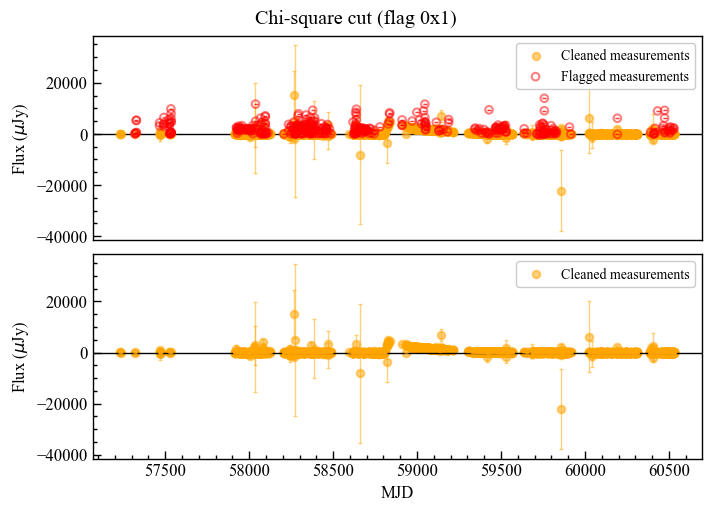

In [13]:
x2_cut = Cut(flag=hexstring_to_int(config["x2_cut"]["flag"]))

lims = plot.get_lims(lc=sn.lcs[0], indices=sn.lcs[0].get_good_indices(x2_cut.flag), xlower=xlim_lower, xupper=xlim_upper, ylower=ylim_lower, yupper=ylim_upper)
print(lims)

plot.plot_cut(sn.lcs[0], x2_cut.flag, lims, title='Chi-square cut', save_filename = 'x2_cut' if save else None)

# Plot the control light curve cut

In [14]:
# Optionally, manually enter the x and y limits:
xlim_lower = None
xlim_upper = None
ylim_lower = None
ylim_upper = None

# Save the plot in the given plot_dir?
save = True

Calculating plot limits using light curve and given indices...
Plot limits: x-axis [None, None], y-axis [None, None]
Saving plot: /Users/sofiarest/Desktop/Supernovae/data_refactor/output/misc/2019vxm/plots/controls_cut.png


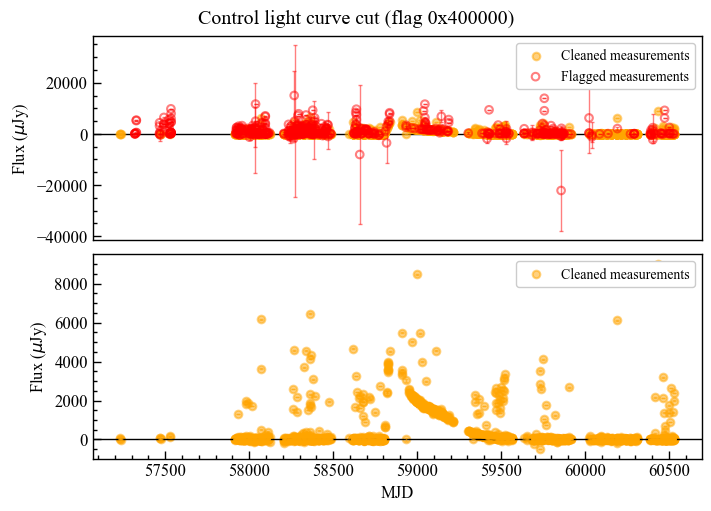

In [15]:
controls_cut = Cut(flag=hexstring_to_int(config["controls_cut"]["bad_flag"]))

lims = plot.get_lims(lc=sn.lcs[0], indices=sn.lcs[0].get_good_indices(controls_cut.flag), xlower=xlim_lower, xupper=xlim_upper, ylower=ylim_lower, yupper=ylim_upper)
print(lims)

plot.plot_cut(sn.lcs[0], controls_cut.flag, lims, title='Control light curve cut', save_filename = 'controls_cut' if save else None)

# Plot custom cut(s)

In [16]:
# Optionally, manually enter the x and y limits:
xlim_lower = None
xlim_upper = None
ylim_lower = None
ylim_upper = None

# Save the plot in the given plot_dir?
save = True

Calculating plot limits using light curve and given indices...
Plot limits: x-axis [None, None], y-axis [None, None]
Saving plot: /Users/sofiarest/Desktop/Supernovae/data_refactor/output/misc/2019vxm/plots/custom_cut.png


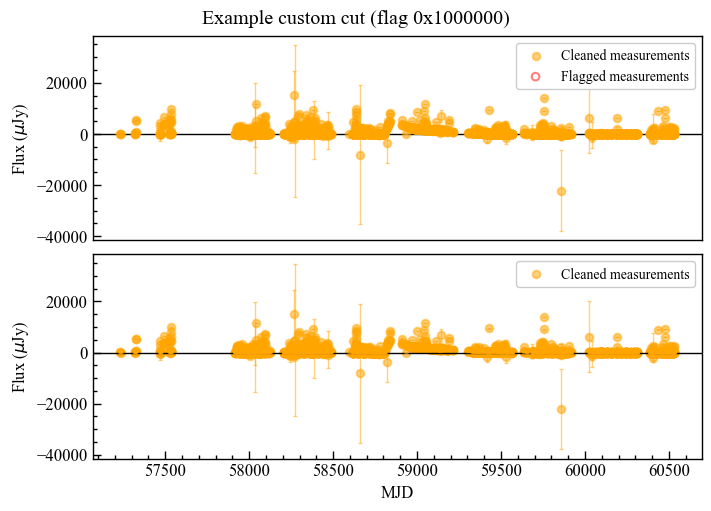

In [17]:
example_custom_cut = Cut(flag=hexstring_to_int(config["example_cut"]["flag"]))

lims = plot.get_lims(lc=sn.lcs[0], indices=sn.lcs[0].get_good_indices(example_custom_cut.flag), xlower=xlim_lower, xupper=xlim_upper, ylower=ylim_lower, yupper=ylim_upper)
print(lims)

plot.plot_cut(sn.lcs[0], example_custom_cut.flag, lims, title='Example custom cut', save_filename = 'custom_cut' if save else None)

# Plot cleaned light curve using all previous cuts

In [18]:
# Optionally, manually enter the x and y limits:
xlim_lower = None
xlim_upper = None
ylim_lower = None
ylim_upper = None

# Save the plot in the given plot_dir?
save = True

Calculating plot limits using light curve and given indices...
Plot limits: x-axis [None, None], y-axis [None, None]
Saving plot: /Users/sofiarest/Desktop/Supernovae/data_refactor/output/misc/2019vxm/plots/all_cuts.png


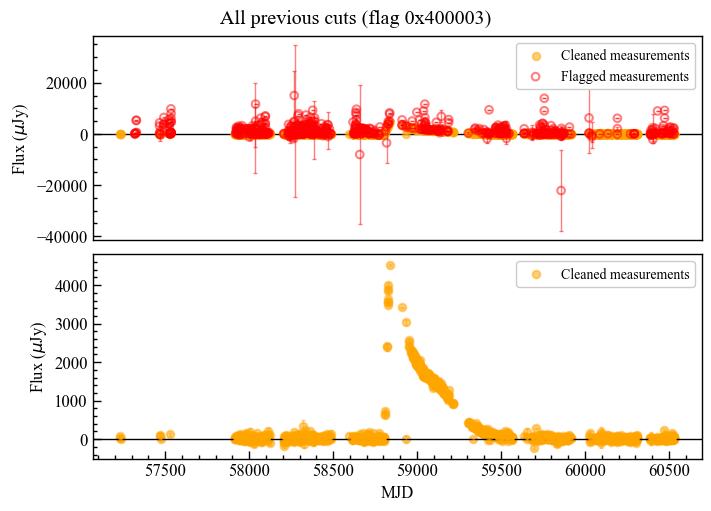

In [19]:
cut_list = CutList()
cut_list.add(uncert_cut, 'uncert_cut')
cut_list.add(x2_cut, 'x2_cut')
cut_list.add(controls_cut, 'controls_cut')
# TODO: add custom cuts to list

lims = plot.get_lims(lc=sn.lcs[0], indices=sn.lcs[0].get_good_indices(cut_list.get_all_flags()), xlower=xlim_lower, xupper=xlim_upper, ylower=ylim_lower, yupper=ylim_upper)
print(lims)

plot.plot_cut(sn.lcs[0], cut_list.get_all_flags(), lims, title='All previous cuts', save_filename = 'all_cuts' if save else None)

In [20]:
# Plot the control light curves?
plot_controls = True

# Plot the SN flagged measurements?
plot_flagged = False

# Optionally, manually enter the x and y limits:
xlim_lower = None
xlim_upper = None
ylim_lower = None
ylim_upper = None

# Save the plot in the given plot_dir?
save = True

Calculating plot limits using light curve and given indices...
Plot limits: x-axis [None, None], y-axis [None, None]
Saving plot: /Users/sofiarest/Desktop/Supernovae/data_refactor/output/misc/2019vxm/plots/cleaned.png


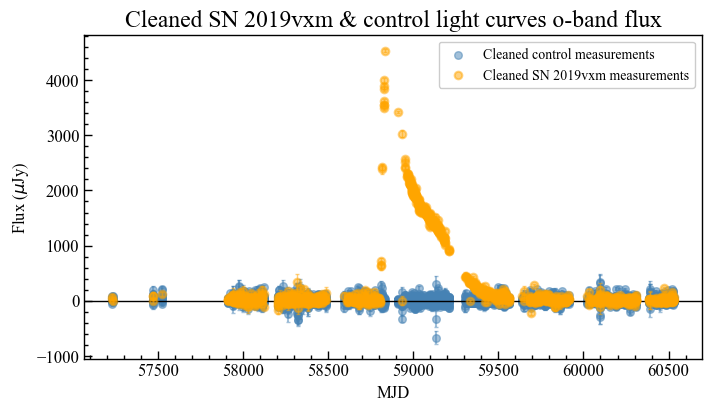

In [21]:
if plot_controls and not load_controls:
	raise RuntimeError('ERROR: No control light curves loaded; set plot_controls to False or load them')

lims = plot.get_lims(lc=sn.lcs[0], indices=sn.lcs[0].get_good_indices(cut_list.get_all_flags()), xlower=xlim_lower, xupper=xlim_upper, ylower=ylim_lower, yupper=ylim_upper)
print(lims)

plot.plot_cleaned_SN(sn, cut_list.get_all_flags(), lims, plot_controls=plot_controls, plot_flagged=plot_flagged, save=save)

# Plot the averaged light curve

In [22]:
# Optionally, manually enter the x and y limits:
xlim_lower = None
xlim_upper = None
ylim_lower = None
ylim_upper = None

# Save the plot in the given plot_dir?
save = True

Calculating plot limits using light curve and given indices...
Plot limits: x-axis [None, None], y-axis [None, None]
Saving plot: /Users/sofiarest/Desktop/Supernovae/data_refactor/output/misc/2019vxm/plots/badday_cut.png


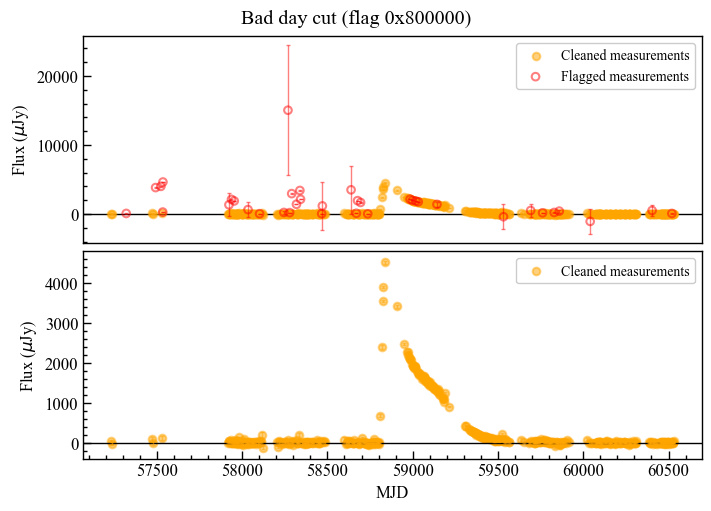

In [23]:
badday_cut = Cut(flag=hexstring_to_int(config["averaging"]["flag"]))

lims = plot.get_lims(lc=avg_sn.avg_lcs[0], indices=avg_sn.avg_lcs[0].get_good_indices(badday_cut.flag), xlower=xlim_lower, xupper=xlim_upper, ylower=ylim_lower, yupper=ylim_upper)
print(lims)

plot.plot_cut(avg_sn.avg_lcs[0], badday_cut.flag, lims, 'Bad day cut', save_filename = 'badday_cut' if save else None)

In [24]:
# Plot the control light curves?
plot_controls = True

# Plot the SN flagged measurements?
plot_flagged = False

# Optionally, manually enter the x and y limits:
xlim_lower = None
xlim_upper = None
ylim_lower = None
ylim_upper = None

# Save the plot in the given plot_dir?
save = True

Calculating plot limits using light curve and given indices...
Plot limits: x-axis [None, None], y-axis [None, None]
Saving plot: /Users/sofiarest/Desktop/Supernovae/data_refactor/output/misc/2019vxm/plots/averaged.png


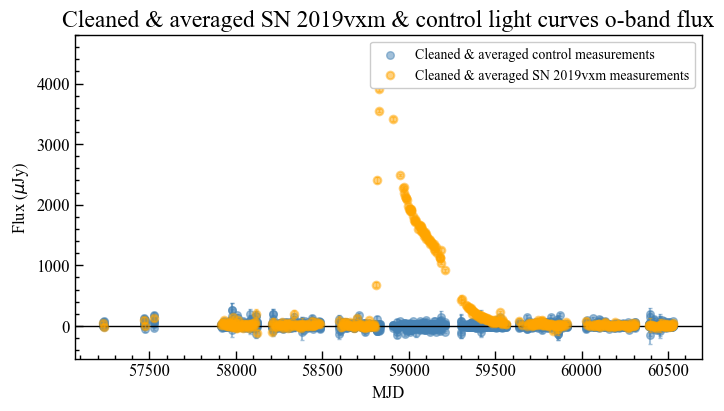

In [25]:
if plot_controls and not load_controls:
	raise RuntimeError('ERROR: No control light curves loaded; set plot_controls to False or load them')

lims = plot.get_lims(lc=avg_sn.avg_lcs[0], indices=avg_sn.avg_lcs[0].get_good_indices(badday_cut.flag), xlower=xlim_lower, xupper=xlim_upper, ylower=ylim_lower, yupper=ylim_upper)
print(lims)

plot.plot_averaged_SN(avg_sn, badday_cut.flag, lims, plot_controls=plot_controls, plot_flagged=plot_flagged, save=save)